# Periodicity Searches with Folding Methods

Folding methods are based on the same premise: given a time series $(t_i, x_i)$ for $i=1, ..., N$ observations, and given a trial period $P_t$ and an arbitrary phase (often, phase $\phi = 0$ is set to the first data point in the time series, $t_0$), calculate the respective phase $phi_i$ corresponding to all other points $t_i$, and fold the time series in phase space. 

To detect a periodic signal, one then splits the resulting phase curve into a set of discrete bins, and compares the statistical properties of the individual bins to the overall statistical properties of the time series. Test statistics are defined such that when a periodic signal is present at a given period $P_s$, the test statistic will take on an extreme value, compared to when only noise is present (or when the period $P$ at which we fold does not correspond to the period of the signal $P_s$). 

In this notebook, we will explore how to calculate two different test statistics on folded light curves: Phase Dispersion Minimization and Epoch Folding.

## Imports

Let's start with some imports

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("white")

from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#000000', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                                                   '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
                                                   '#bcbd22', '#17becf'])


import numpy as np

from stingray import Lightcurve

figdir = "/Users/daniela/work/repositories/periodicity_review/figures/"

## Generating Data

For this example, let us generate a simple data set of a sinusoidal, periodic signal in the presence of instrumental noise. We will assume simple Gaussian noise here, but the methods can be easily be generalized to other distributions (e.g. Poisson noise from X-ray and gamma-ray photon counting detectors):

In [2]:
def sinusoid(times, frequency, baseline, amplitude, phase):
    """
    Calculate a sinusoidal curve.
    
    Parameters
    ----------
    times : iterable
        A list of time stamps at which to compute the sinusoidal signal
    
    frequency : float
        The frequency of the sinusoidal signal
        
    baseline : float
        The mean flux around which the signal varies
        
    amplitude : float
        The amplitude of the sinusoidal signal
        
    phase : float
        The phase of the sinusoidal signal
    
    Returns
    -------
    sine : iterable
        The sinusoidal signal (plus the baseline) at the time 
        stamps given in `times`
    """
    sine = amplitude * np.sin(2 * np.pi * (frequency * times + phase))
    return baseline + sine

In [3]:
from stingray.events import EventList

In [4]:
# set random seed for reproducibility
np.random.seed(200)

period = 1.2 # the period of the sinusoid
mean_flux = 20 # the mean flux around which the periodic signal varies
pulsed_fraction = 0.05 # the fraction of the total signal that is pulsed
dt = 0.001 # the time resolution of the time series
obs_length = 500 # the total length of the observation

# generate time stamps
t = np.arange(0, obs_length, dt)

# convert to parameters for the sinusoid function
frequency = 1./period
amplitude = 0.5 * mean_flux * pulsed_fraction
phase = 0.0

model_flux = sinusoid(t, frequency, mean_flux, amplitude, phase)

# uncertainties in the flux
sigma = 2.0

# calculate flux with uncertainties
raw_flux = np.random.normal(model_flux, sigma)

# store in a stingray.Lightcurve object
lc = Lightcurve(t, raw_flux, gti=[[-dt / 2, obs_length + dt / 2]], dt=dt)

evt = EventList.from_lc(lc)

Let's plot the light curve to see what it looks like:

<IPython.core.display.Javascript object>


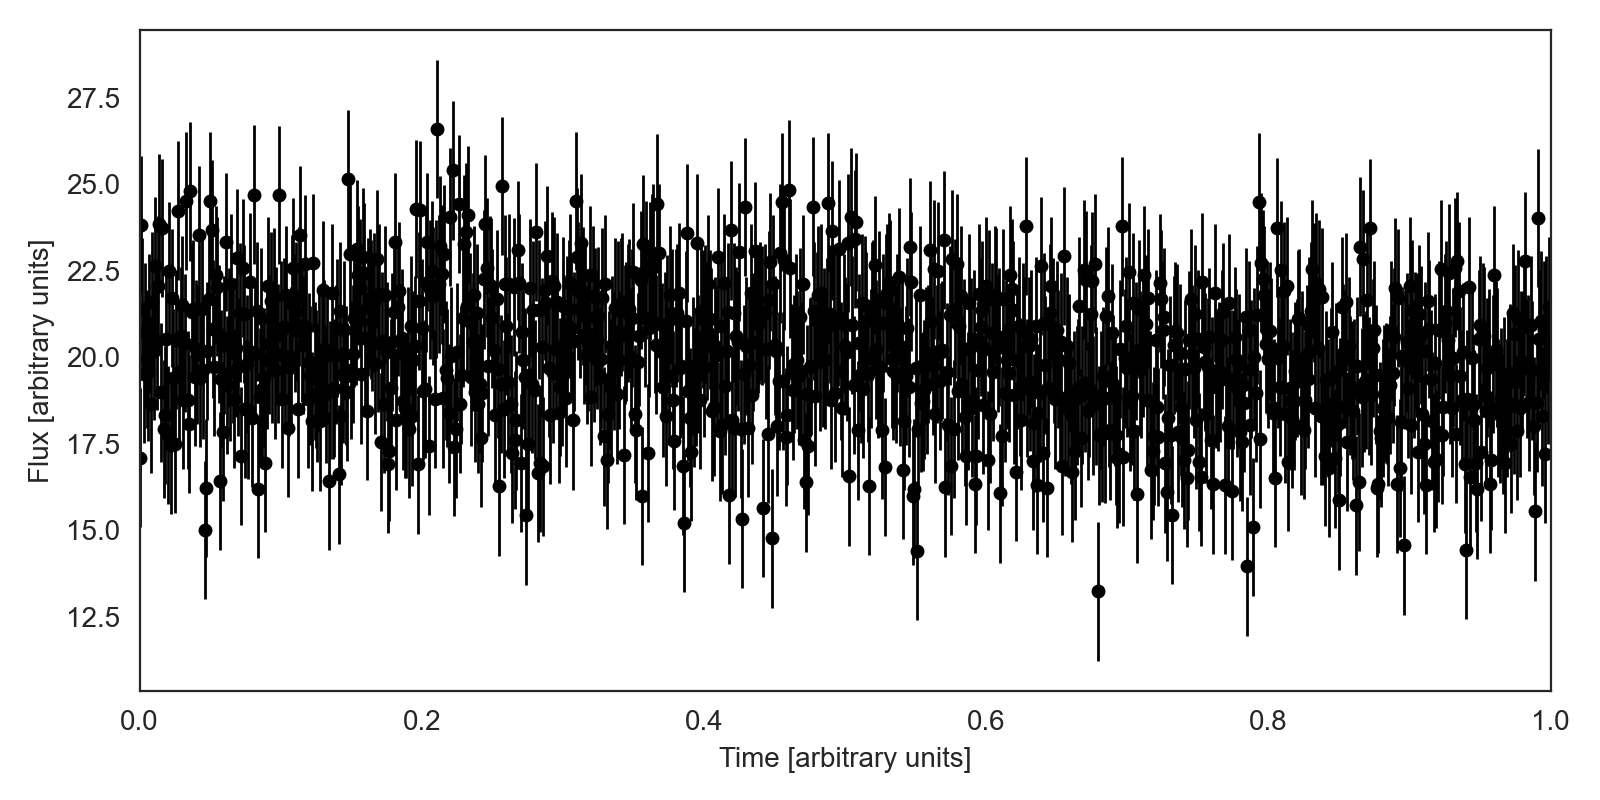

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

# plot only a small segment to actually see what's going on
max_idx = 1000

ax.errorbar(lc.time[:max_idx], lc.counts[:max_idx], yerr=sigma, fmt="o", color="black",
            markersize=4, lw=1)
ax.set_xlabel("Time [arbitrary units]")
ax.set_ylabel("Flux [arbitrary units]")

ax.set_xlim(lc.time[0], lc.time[max_idx])

fig.tight_layout()
fig.savefig(f"{figdir}ef_lc.pdf", format="pdf")

Hard to see anything really! What happened to our periodic signal? Is it in there? Let's find out! 

## Phase Folding

Next, we'd like to phase-fold the data. We'll do this for two different periods: at exactly the period at which we generated the signal, and also at a different period, so that we can observe the difference.

In `stingray`, the `pulse` module has a range of functionality to phase-fold data and work with it. Note that `stingray` was originally designed to work mainly with X-ray data, i.e. photon counting data, subject to Poisson noise. It is perfectly reasonable to use on our data here (with Gaussian noise), but this is why `Lightcurve` has an attribute `counts` rather than `flux`, which you might be more familiar with, and this is also why `fold_events` by default expects *photon event data*, rather than a light curve. We can make it use a light curve by setting the `weights` keyword:

In [7]:
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile

<IPython.core.display.Javascript object>


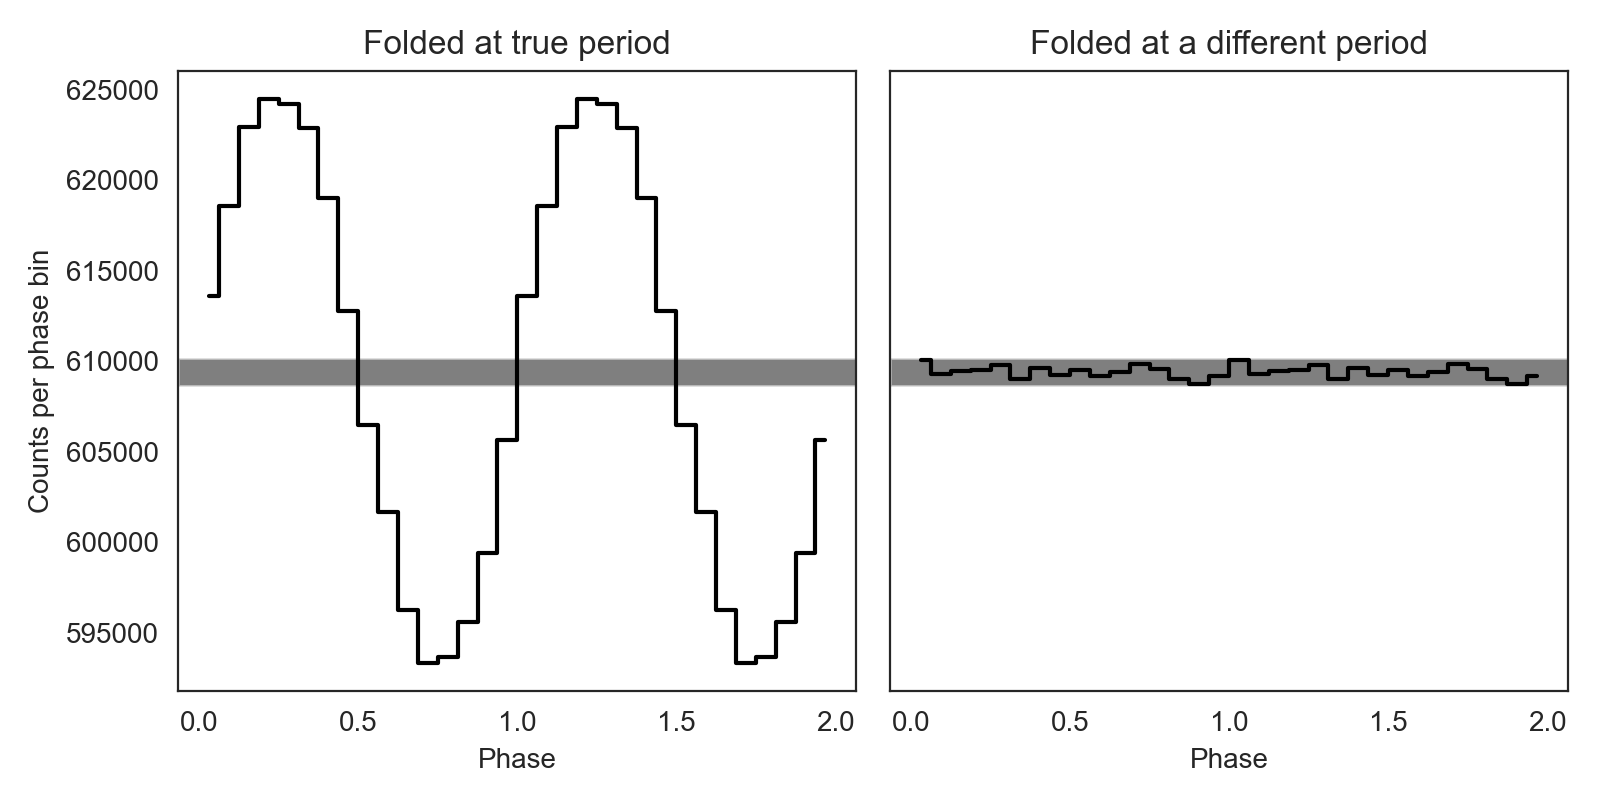

In [8]:
# number of bins in the phase-folded light curve
nbin = 16

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

#ph1, profile1, profile_err1 = fold_events(lc.time, 1./period, nbin=nbin, weights=lc.counts)
ph1, profile1, profile_err1 = fold_events(evt.time, 1./period, nbin=nbin)
_ = plot_profile(ph1, profile1, ax=ax1)
ax1.set_title("Folded at true period")
ax1.set_ylabel("Counts per phase bin")
#ph2, profile2, profile_err2 = fold_events(lc.time, 1.1, nbin=nbin, weights=lc.counts)
ph2, profile2, profile_err2 = fold_events(evt.time, 1.5, nbin=nbin)
_ = plot_profile(ph2, profile2, ax=ax2,)
ax2.set_title("Folded at a different period")
ax2.set_ylabel("")

fig.tight_layout()
fig.savefig(f"{figdir}ef_folded.pdf", format="pdf")

Joint plot for the paper:

<IPython.core.display.Javascript object>


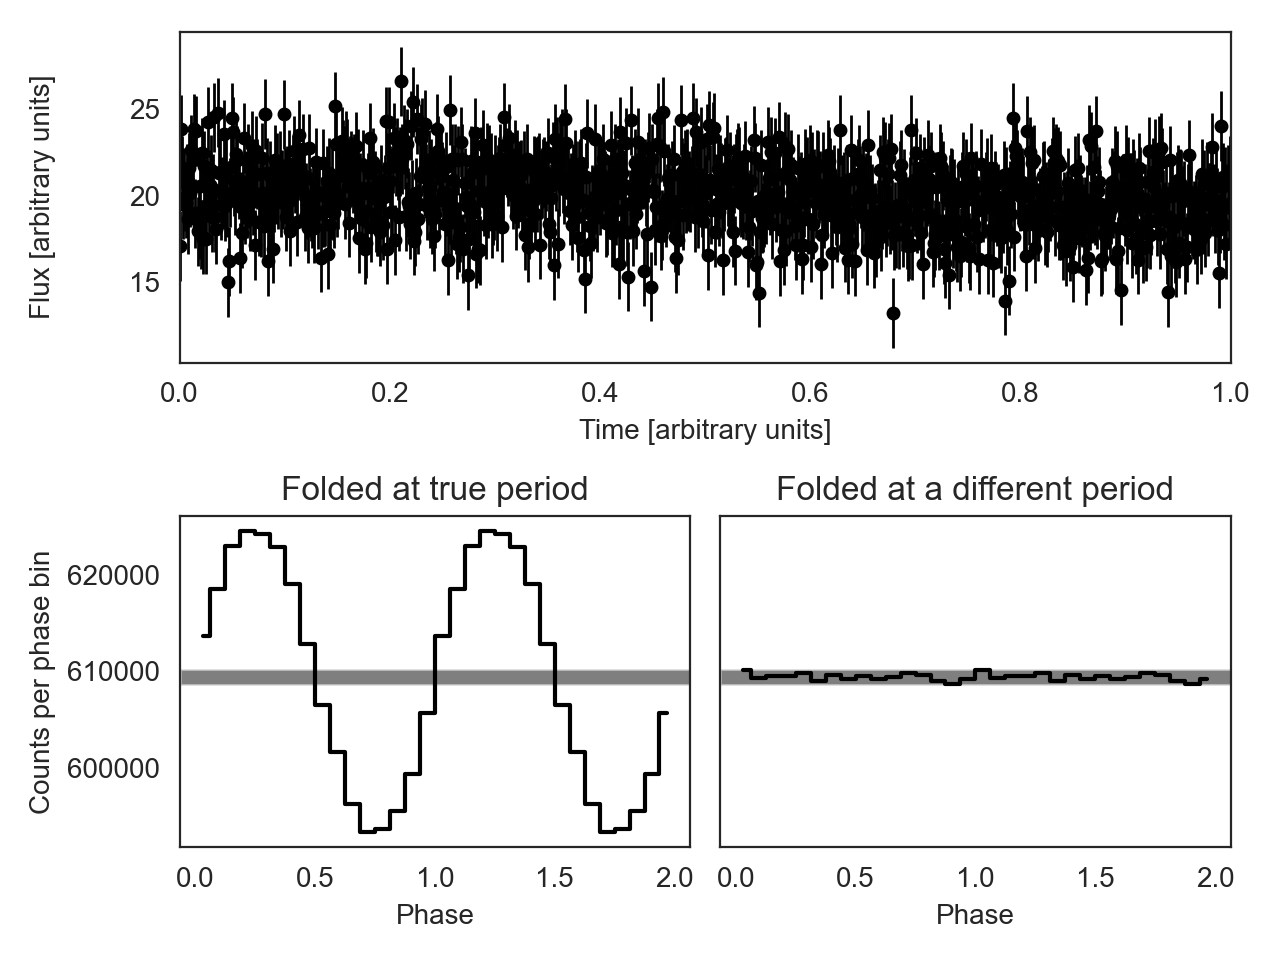

In [9]:
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.errorbar(lc.time[:max_idx], lc.counts[:max_idx], yerr=sigma, fmt="o", color="black",
            markersize=4, lw=1)
ax.set_xlabel("Time [arbitrary units]")
ax.set_ylabel("Flux [arbitrary units]")

ax.set_xlim(lc.time[0], lc.time[max_idx])

ax1 = fig.add_subplot(gs[1, 0])
#ph1, profile1, profile_err1 = fold_events(lc.time, 1./period, nbin=nbin, weights=lc.counts)
ph1, profile1, profile_err1 = fold_events(evt.time, 1./period, nbin=nbin)
_ = plot_profile(ph1, profile1, ax=ax1)
ax1.set_title("Folded at true period")
ax1.set_ylabel("Counts per phase bin")

ax2 = fig.add_subplot(gs[1, 1])
#ph2, profile2, profile_err2 = fold_events(lc.time, 1.1, nbin=nbin, weights=lc.counts)
ph2, profile2, profile_err2 = fold_events(evt.time, 1.5, nbin=nbin)
_ = plot_profile(ph2, profile2, ax=ax2,)
ax2.set_title("Folded at a different period")
ax2.set_ylabel("")

ax2.set_ylim(ax1.get_ylim())
ax2.get_yaxis().set_visible(False)


fig.align_labels() 
fig.savefig(f"{figdir}ef_lc_folded.pdf", format="pdf")

From the plots above, it's immediately obvious that folding at the true period will result in a clear (sinusoidal) pattern in the folded light curve, whereas folding at a different period produces a very noisy, but overall flat-appearing light curve. Less immediately obvious is the fact that the overall variance in the phase-folded light curve is also much larger when folded at the true period than when folded at a different period (note that the y-axes of both plots are at different scales.

This is the basis of searching for periodic signals with folding methods. The two methods most often used differ only in the construction of the test statistic used for periodicity searches. In *epoch folding*, one computes the means of the observations grouped for each phase bin, and compares the variance in those means to the overall variance of the data. In *Phase Dispersion Minimization*, conversely, one computes the variance of measurements grouped into each bins, and compares that variance to the overall variance. Both are based on the idea that when a light curve is folded at the true period, observations at the same phase are added coherently, such that the mean of observations in a phase bin will deviate significantly from the overall mean of the light curve (compared to noise), and the variance within a phase bin will be minimized (also compared to noise).

Let's look at both more closely.

## Epoch Folding

For Epoch Folding, we can calculate the Epoch Folding statistic for a given phase-folded profile, also implemented in stingray:

In [10]:
from stingray.pulse.pulsar import ef_profile_stat

In [11]:
print(f"Epoch folding statistic at true period: {ef_profile_stat(profile1)}")
print(f"Epoch folding statistic at different period: {ef_profile_stat(profile2)}")

Epoch folding statistic at true period: 3408.037523233379
Epoch folding statistic at different period: 3.0402384734597203


Notice how much larger the statistic is at the true period! In practice, we often want to search many trial periods, rather than guess individual periods. 

The periods over which we can search are limited by the details of the observation. The largest period we can search corresponds to the overall length of the time series (we need at least one full cycle in order to measure a period) and the time resolution (we cannot measure periodic variations smaller than the time resolution of the light curve). In `stingray`, the grid is parametrized as frequencies rather than periods.


In [12]:
from stingray.pulse.search import epoch_folding_search

In [13]:
df_min = 1/obs_length # frequency resolution, independent frequencies
nbin = 16

oversampling = 1.0 # oversampling factor

df = df_min / oversampling # frequency resolution with oversampling

# normally fmax = 0.5/dt, but we're setting it to 1.5 here to 
# keep computation time manageable
fmax = 1.5 # maximum frequency to search

# set up array of frequencies
frequencies = np.arange(df, fmax, df)

# compute epoch folding statistic for all trial frequencies
freq, efstat = epoch_folding_search(lc.time, frequencies, nbin=nbin, weights=lc.counts)


<IPython.core.display.Javascript object>


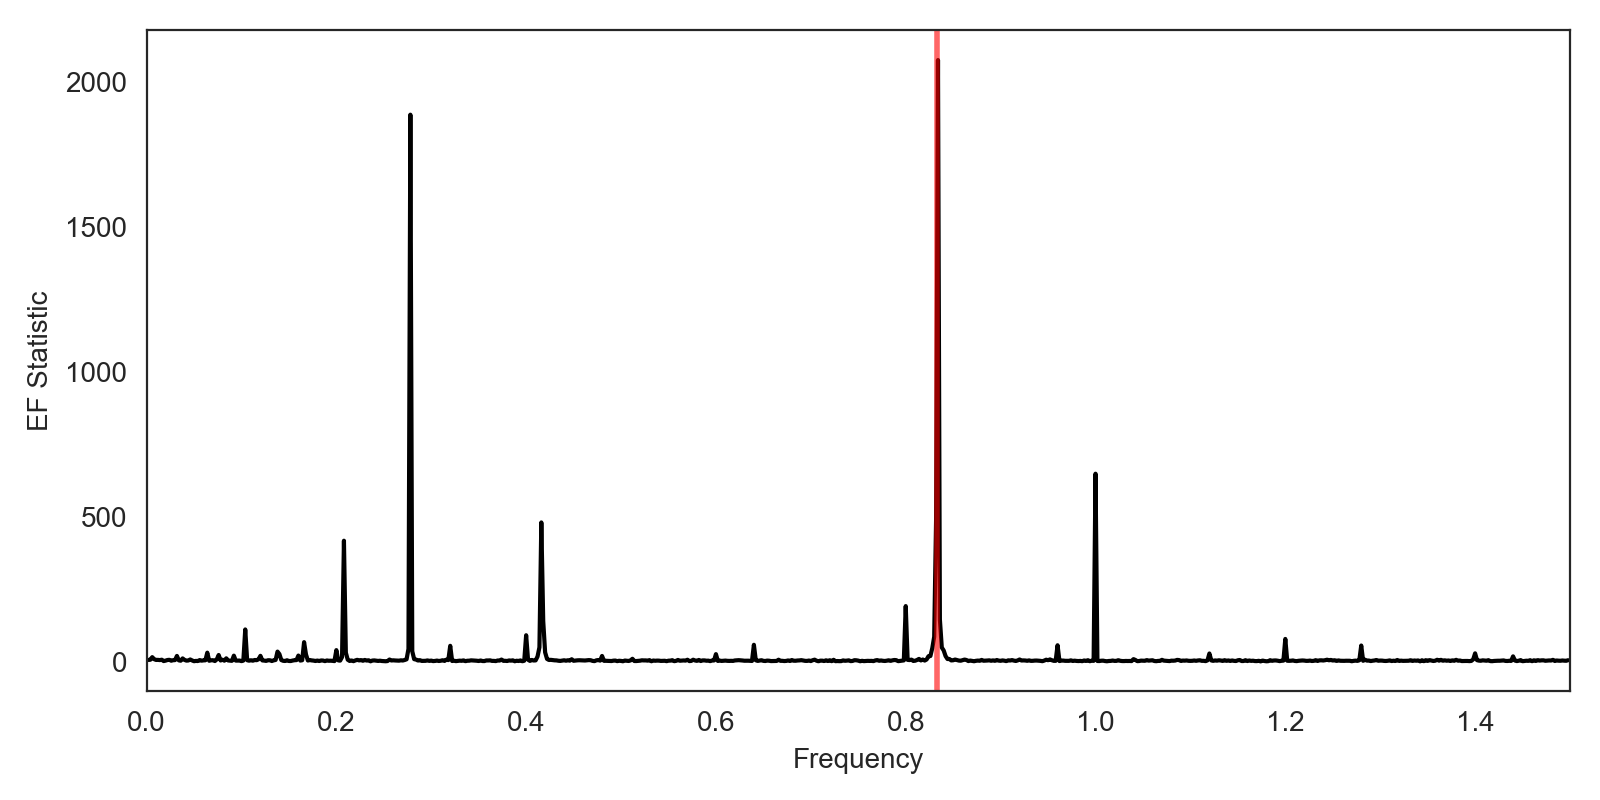

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(freq, efstat, color="black")
ax.axvline(1./period, lw=2, color="red", alpha=0.6)
ax.set_xlim(0, 1.5)
#ax.set_ylim(0, 4000)
ax.set_xlabel("Frequency")
ax.set_ylabel("EF Statistic")

fig.tight_layout()


You can see that the statistic has peaks at a range of different frequencies, with the highest peak at the true frequency of the signal we injected. The presence of these various peaks is not unexpected: we have regularly sampled the time series (`dt` is the same for all bins) and we've also picked a discrete set of `nbins` for our phase-folded light curve. The combination of these time scales we've had to choose, along with the period of the true signal in the data, can cause beat frequencies, where spurious signals might appear. A quick way to check whether a peak might be real or not is by choosing a different `dt` and a different number of `nbins`. If they are beat frequencies, the peaks will disappear or move to a different frequency. If they do shift or change significantly, you should probably ignore them as due to beat frequencies.

Assuming that a peak is probably not due to beat frequencies, how do we know in practice whether any given peak is significant?

For this, we have to compare the value of the Epoch Folding statistic at a candidate frequency (say, the frequency with the highest peak) to the values we would expect for the EF statistic if only noise is present in the light curve (and no periodic signal). This corresponds to a *null hypothesis test*, where our null hypothesis is that only noise due to the detector is present in the data. 

[Leahy et al (1983)]() showed that the epoch folding statistic under the assumption of only noise follows a $\chi^2$ distribution, which we can use to set a detection threshold.

To make things more easily visible, let's zoom in on our candidate signal, i.e. the highest peak as well:

In [15]:
from stingray.stats import fold_detection_level

In [16]:
df_min = 1/obs_length # frequency resolution, independent frequencies

oversampling = 5.0 # oversampling factor

df = df_min / oversampling # frequency resolution with oversampling

# set up array of frequencies
frequencies_zoom = np.arange(1./period - 200*df, 1./period + 200*df, df )

# compute epoch folding statistic for all trial frequencies
freq_zoom, efstat_zoom = epoch_folding_search(lc.time, frequencies_zoom, 
                                              nbin=nbin, weights=lc.counts)


In [17]:
ef_detec_level = fold_detection_level(nbin, epsilon=0.001, ntrial=1)

<IPython.core.display.Javascript object>


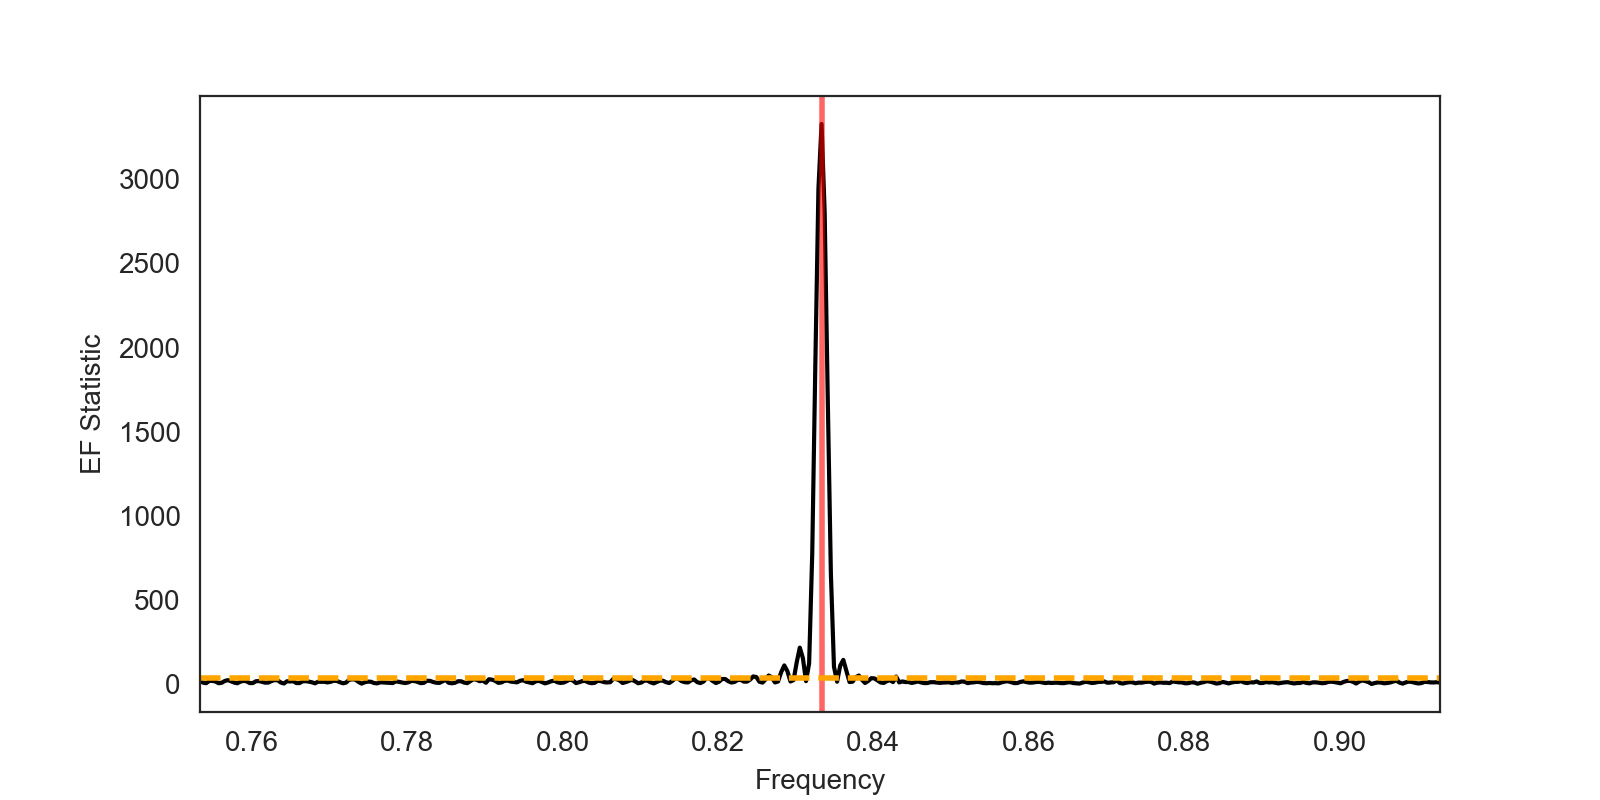

Text(0, 0.5, 'EF Statistic')

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(freq_zoom, efstat_zoom, color="black")
ax.axvline(1./period, lw=2, color="red", alpha=0.6)
ax.axhline(ef_detec_level, lw=2, color="orange", ls="dashed")
ax.set_xlim(freq_zoom[0], freq_zoom[-1])
ax.set_xlabel("Frequency")
ax.set_ylabel("EF Statistic")

According to the orange dashed line (our detection limit), the signal at the true period is clearly significant. Notice, however, also the peaks at the lowest frequencies, where there also seems to be significant power. This is a spurious effect (clearly, since we know exactly what we put into the data). 

**Be careful**: The nature of a null hypothesis test *only* allows you to *reject* that null hypothesis (here: that the highest peak we are interested in can be explained by independent and identically distributed Gaussian noise), and it is *not* direct evidence for the alternative hypothesis you actually would like to know (there is a periodic signal in the data). The conclusion that there might actually be a periodic signal in the data is *only* true if you've excluded *every other hypothesis* that could explain the observed power. In our case here, remember that our data collection process and the data analysis itself also impose temporal structure on the data, in the form of the sampling time `dt` and the number of bins `nbin`, which will also show up in our periodogram. Other methods might also make assumptions that are often not explicitly stated, but that can, when they are not met, cause spurious signals in the data. Be very careful and double-check the assumptions of your method, and what else could generate a signal, before you conclude it is a real periodic signal.

The dashed line can only tell us where there are peaks that are above our threshold, but ideally, we'd actually like to associate a *probability* with our peak. Under the null hypothesis, how probable is it that we would observe a peak this high?

To do this, we calculate the *tail probability* or *p-value* of the relevant probability distribution, here a $\chi^2$ distribution. It integrates the probability density above the value of the highest peak, and thus gives you the probability of observing a signal at least as high as the highest power under the null hypothesis that there is only noise in the data. 

Here's how we can calculate that:

In [19]:
from stingray.stats import fold_profile_probability

In [20]:
maxpow = np.max(efstat) # maximum of the folding periodogram
maxfreq = freq[np.argmax(efstat)] # associated frequency
print(f"The maximum power {maxpow} is observed at f = {maxfreq}")

pval = fold_profile_probability(maxpow, nbin, ntrial=1)
print(f"The p-value associated with the maximum power is p = {pval}")

The maximum power 2073.928279362539 is observed at f = 0.8340000000000001
The p-value associated with the maximum power is p = 0.0


/opt/miniconda3/envs/stingraydev/lib/python3.8/site-packages/stingray-1.1.dev3+gd8a1a13.d20230405-py3.8.egg/stingray/stats.py:275: RuntimeWarning: divide by zero encountered in log
  np.log(p1).astype(np.double), n)


Here, the p-value is zero, indicating that really, there isn't *any* chance that the observed power is due to noise alone. Sometimes, when we're really far out in the low-probability regions of the distribution, the probability drops below numerical precision. If you still want an estimate, you can calculate the log-probability instead:

In [21]:
from stingray.stats import fold_profile_logprobability

log_pval = fold_profile_logprobability(maxpow, nbin)
print(f"The log of the p-value associated with the maximum power is {log_pval}")

The log of the p-value associated with the maximum power is -999.3558799271814


Okay, that really is very small. There is one more subtlety to take into account here that is important. Notice how we set `ntrial=1` for both the detection level and the probability. `ntrial` sets the number of trials, i.e.~how often you calculated an epoch folding statistic in search of your highest peak. The reason we need to correct for this is that we are dealing with probabilities: for example, by setting a threshold of `0.001` above, we said that we want the detection threshold such that our chance of finding an outlier by chance (due to noise) is 1/1000. But if we search 1000 frequencies, then we would expect to see one outlier above that detection threshold purely by chance due to noise, and so if we observe one, we cannot be sure whether it is likely due to a signal, or due to a chance outlier. Thus, we need to correct our detection limit for the number of epoch folding statistics we have calculated, in order to not mistake a chance outlier for a real signal.

But what should we assume for `ntrial`? Excellent question, and unfortunately one without a general answer! It kind of depends on where you started with your search. Imagine, for example, that you are looking at a pulsar for which you already know a pulse period from radio observations, and now you'd like to see if it is present in X-rays as well. Here, you might look at the EF statistic at *one specific frequency* (i.e. at the frequency found in radio observations) and `ntrial=1` is correct, because you're not searching over many different frequencies. But maybe you have observed the pulsar in X-rays three times, and search each of these observations separately. Then probably `ntrial=3`. 

Now imagine you have an observation of a source, and you'd like to search for pulsations. You don't really know at which frequency that signal might be, so you search the entire possible range, as we've done above. In this case, `ntrial` should be at least the *number of independent frequencies* for which you calculated an EF statistic. 

What is the number of independent frequencies? Well, for our case above it would be the length of `frequencies`, calculated between `df` and `fmax` without oversampling. Oversampling will generate a more narrowly spaced frequency array, but the EF statistic for neighbouring frequencies will not be independent. 

For unevenly sampled data, things get more complicated, and we refer the reader to an excellent discussion in Jake VanderPlas' [paper on Lomb-Scargle periodograms]() for more information.

For now, let's calculate the number of independent frequencies as `ntrial` and then recalculate our detection threshold and probability:

The number of independent frequencies is 749
The p-value associated with the maximum power is p = -992.7371409436641


<IPython.core.display.Javascript object>


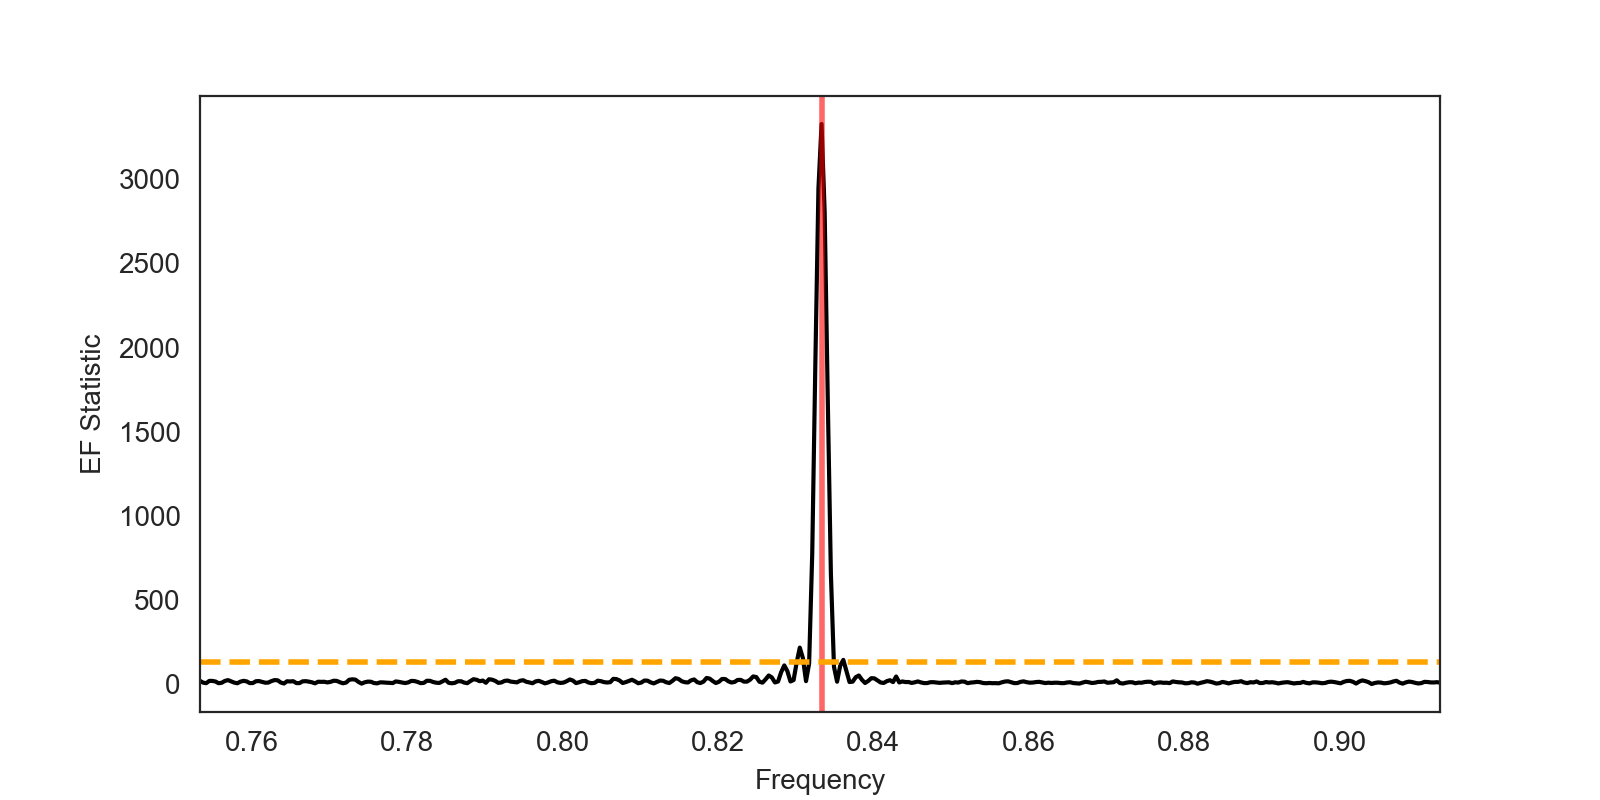

Text(0, 0.5, 'EF Statistic')

In [22]:
ntrial = len(frequencies)
print(f"The number of independent frequencies is {ntrial}")

ef_detec_level = fold_detection_level(64, epsilon=0.001, ntrial=len(freq))
log_pval = fold_profile_logprobability(maxpow, nbin, ntrial=len(freq))

print(f"The p-value associated with the maximum power is p = {log_pval}")

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(freq_zoom, efstat_zoom, color="black")
ax.axvline(1./period, lw=2, color="red", alpha=0.6)
ax.axhline(ef_detec_level, lw=2, color="orange", ls="dashed")
ax.set_xlim(freq_zoom[0], freq_zoom[-1])
ax.set_xlabel("Frequency")
ax.set_ylabel("EF Statistic")

<IPython.core.display.Javascript object>


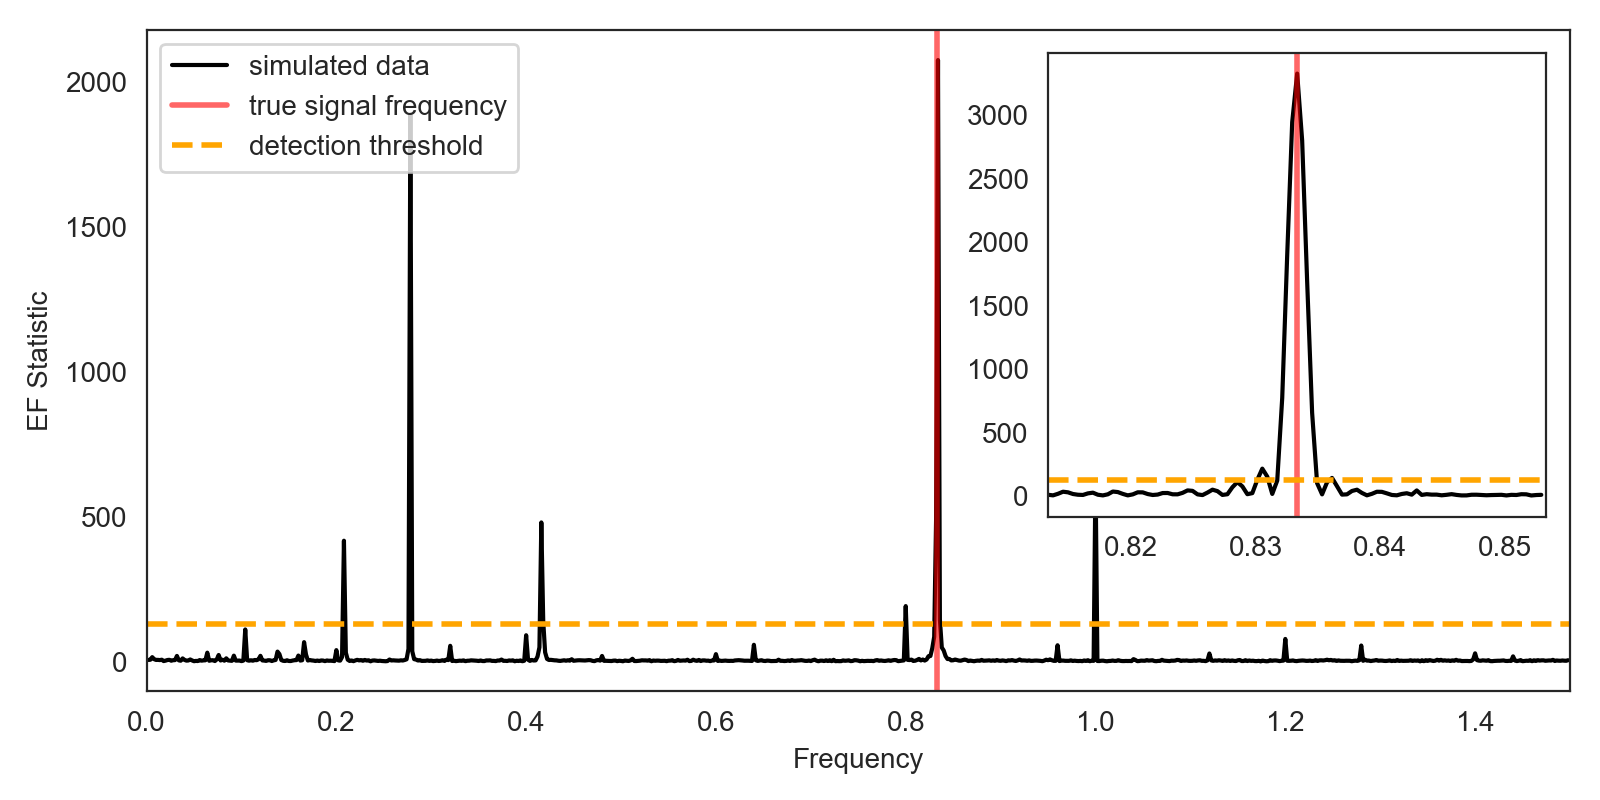

In [28]:
#from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
#                                                  mark_inset)
from matplotlib import lines
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox


fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(freq, efstat, color="black", label="simulated data")
ax.axvline(1./period, lw=2, color="red", alpha=0.6, label="true signal frequency")
ax.axhline(ef_detec_level, lw=2, color="orange", ls="dashed", label="detection threshold")

ax.set_xlim(0, 1.5)
#ax.set_ylim(0, 4000)
ax.set_xlabel("Frequency")
ax.set_ylabel("EF Statistic")
ax.legend(loc="upper left")
fig.tight_layout()

bb_data_ax2 = Bbox.from_bounds(0.95, 500, 0.525, 1600)
disp_coords = ax.transData.transform(bb_data_ax2)
fig_coords_ax2 = fig.transFigure.inverted().transform(disp_coords)
bb_ax2 = Bbox(fig_coords_ax2)
ax2 = fig.add_axes(bb_ax2)

ax2.plot(freq_zoom[150:250], efstat_zoom[150:250], color="black")
ax2.axvline(1./period, lw=2, color="red", alpha=0.6)
ax2.axhline(ef_detec_level, lw=2, color="orange", ls="dashed")
ax2.set_xlim(freq_zoom[150], freq_zoom[250])

fig.savefig(f"{figdir}ef_stat.pdf", format="pdf")

Well, that didn't change very much overall, but that is because the signal in the data is really quite significant!

Out of curiosity, let's check what happens if we generate a light curve of *only* noise and generate an epoch folding periodogram:

<IPython.core.display.Javascript object>


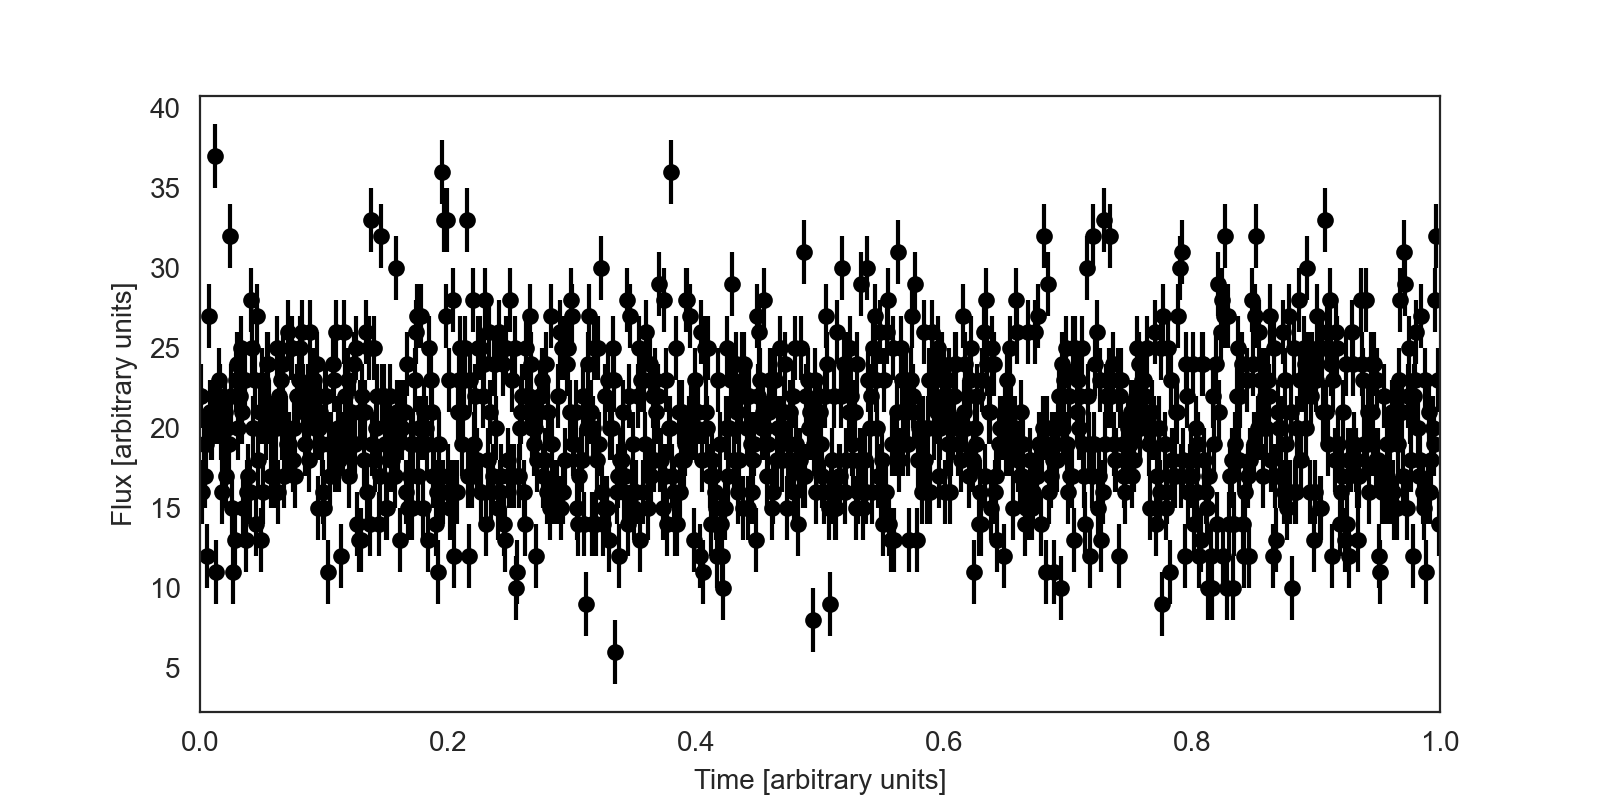

Text(0, 0.5, 'Flux [arbitrary units]')

In [30]:
# set amplitude of the sinusoid to zero, we'll get only the constant baseline back
noise_model_flux = np.ones_like(t) * mean_flux

# uncertainties in the flux
sigma = 2.0

# calculate flux with uncertainties
#noise_raw_flux = np.random.normal(noise_model_flux, sigma)
noise_raw_flux = np.random.poisson(noise_model_flux)

# store in a stingray.Lightcurve object
lc_noise  = Lightcurve(t, noise_raw_flux, gti=[[-dt / 2, obs_length + dt / 2]], dt=dt)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.errorbar(lc_noise.time[:max_idx], lc_noise.counts[:max_idx], yerr=sigma, 
            fmt="o", markersize=5, color="black")
ax.set_xlim(lc_noise.time[0], lc_noise.time[max_idx])
ax.set_xlabel("Time [arbitrary units]")
ax.set_ylabel("Flux [arbitrary units]")

What is the epoch folding periodogram for this light curve?

In [31]:
# compute epoch folding statistic for all trial frequencies
freq, efstat_noise = epoch_folding_search(lc_noise.time, frequencies, 
                                          nbin=nbin, weights=lc_noise.counts)

<IPython.core.display.Javascript object>


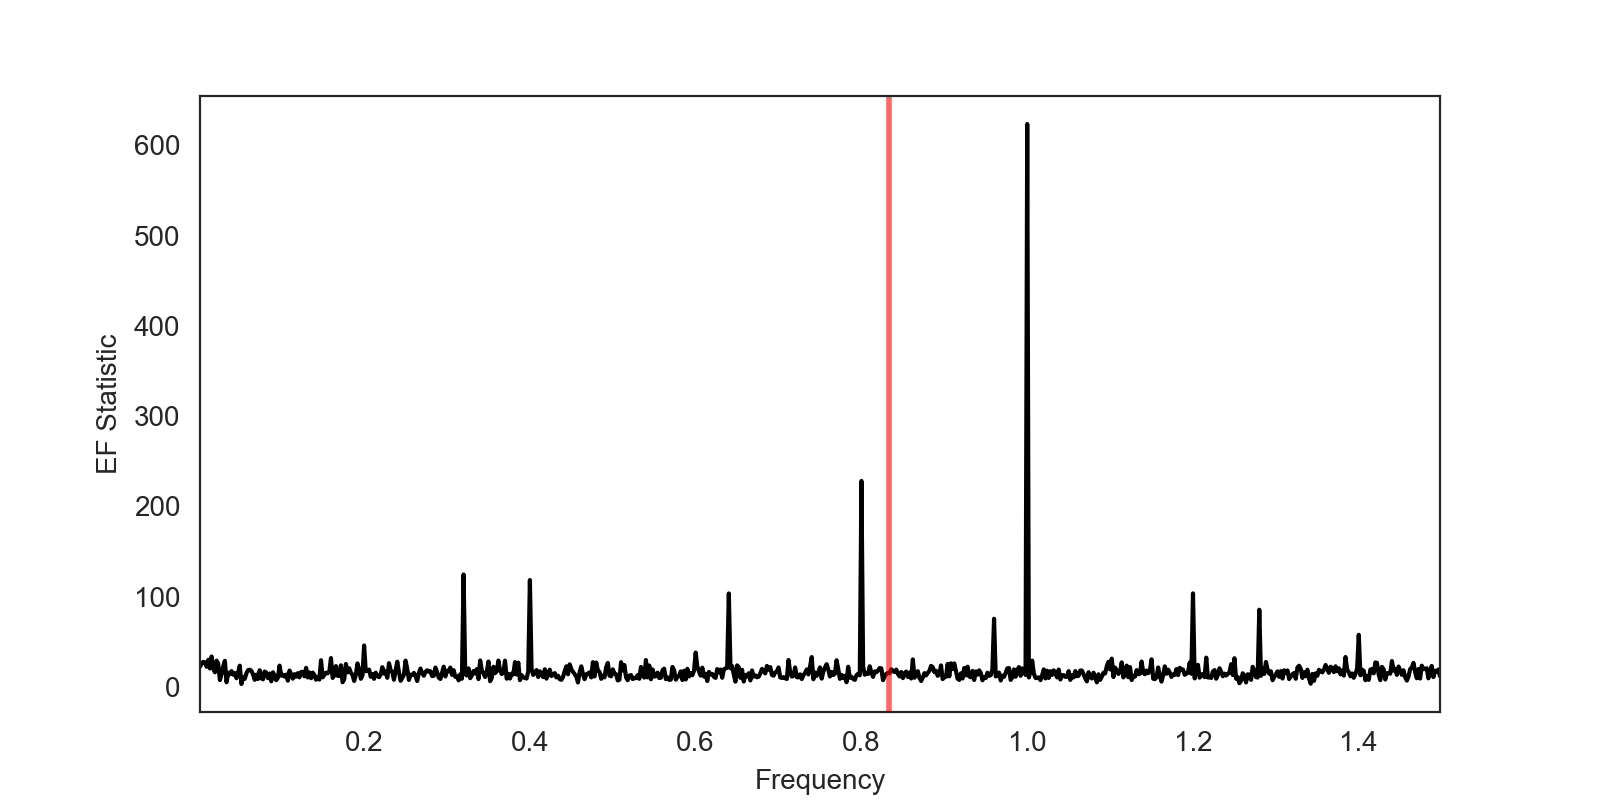

Text(0, 0.5, 'EF Statistic')

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(freq, efstat_noise, color="black")
ax.axvline(1./period, lw=2, color="red", alpha=0.6)
ax.set_xlim(freq[0], freq[-1])
ax.set_xlabel("Frequency")
ax.set_ylabel("EF Statistic")

As we can see, there are *still* pretty tall peaks in the epoch folding periodogram, but not at the frequency where we put the period into the original data. Let's calculate another periodogram of the same data, but chance `nbin` to see if the signal we see at ~1 Hz could be due to a beat frequency between `nbin` and the time resolution:

In [33]:
nbin_new = 40

In [34]:
# compute epoch folding statistic for all trial frequencies
freq, efstat_noise = epoch_folding_search(lc_noise.time, frequencies, 
                                          nbin=nbin_new, weights=lc_noise.counts)

<IPython.core.display.Javascript object>


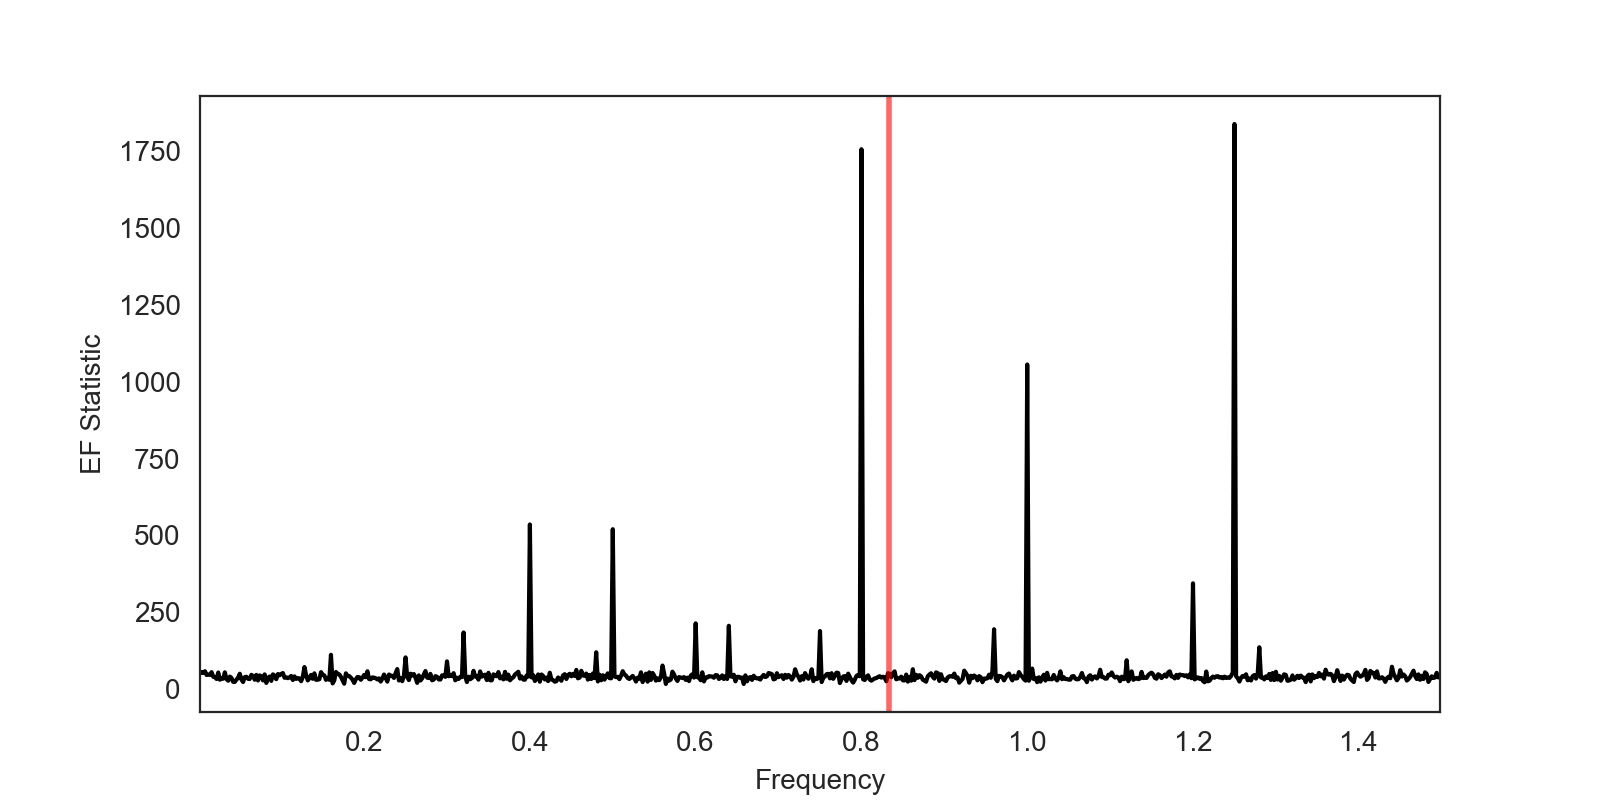

Text(0, 0.5, 'EF Statistic')

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(freq, efstat_noise, color="black")
ax.axvline(1./period, lw=2, color="red", alpha=0.6)
ax.set_xlim(freq[0], freq[-1])
ax.set_xlabel("Frequency")
ax.set_ylabel("EF Statistic")

Well, the signal at 1 Hz has become much smaller, but new ones have appeared at 0.8 and 1.3. So be very careful when finding a peak! Try changing the time resolution and/or `nbin`: if the signal vanishes or moves, it's probably not real.

**Note**: You might also want to check whether other effects during the data detection could have imprinted a time signature onto your data. The day-long periods due to the Earth's rotation, signals associated with the orbit of a satellite around the Earth, and regular records of internal housekeeping data of a telescope have all been claimed as true astronomical signals in the astronomy literature at one time or another! If in doubt, talk to someone who has lots of experience with the instrument!

### Measuring the Period

Above, we simply found the frequency at which we observe the maximum power and use that frequency as the pulsation frequency. In practice, however, we can often do better by fitting a function to the (oversampled) pulse profile, which [Leahy et al (1983?)]() showed to be a sinc function (for a stable oscillation period across the observation). For more details, refer to the paper above, or the relevant [`stingray` documentation]().

## Phase Dispersion Minimization

Phase dispersion minimization works similarly on a folded light curve as Epoch Folding above, but differs in the test statistic it uses. It operates on the insight that when variability in a light curve is due to a periodic signal (and instrumental noise), then the variance within each bin of the phase-folded light curve should be minimized when the light curve is folded at the true period, compared to when it is folded at other periods. 

Let's give this a try. For this, we'll need to fold the light curve again, but set the `mode` keyword to `pdm`:


<IPython.core.display.Javascript object>


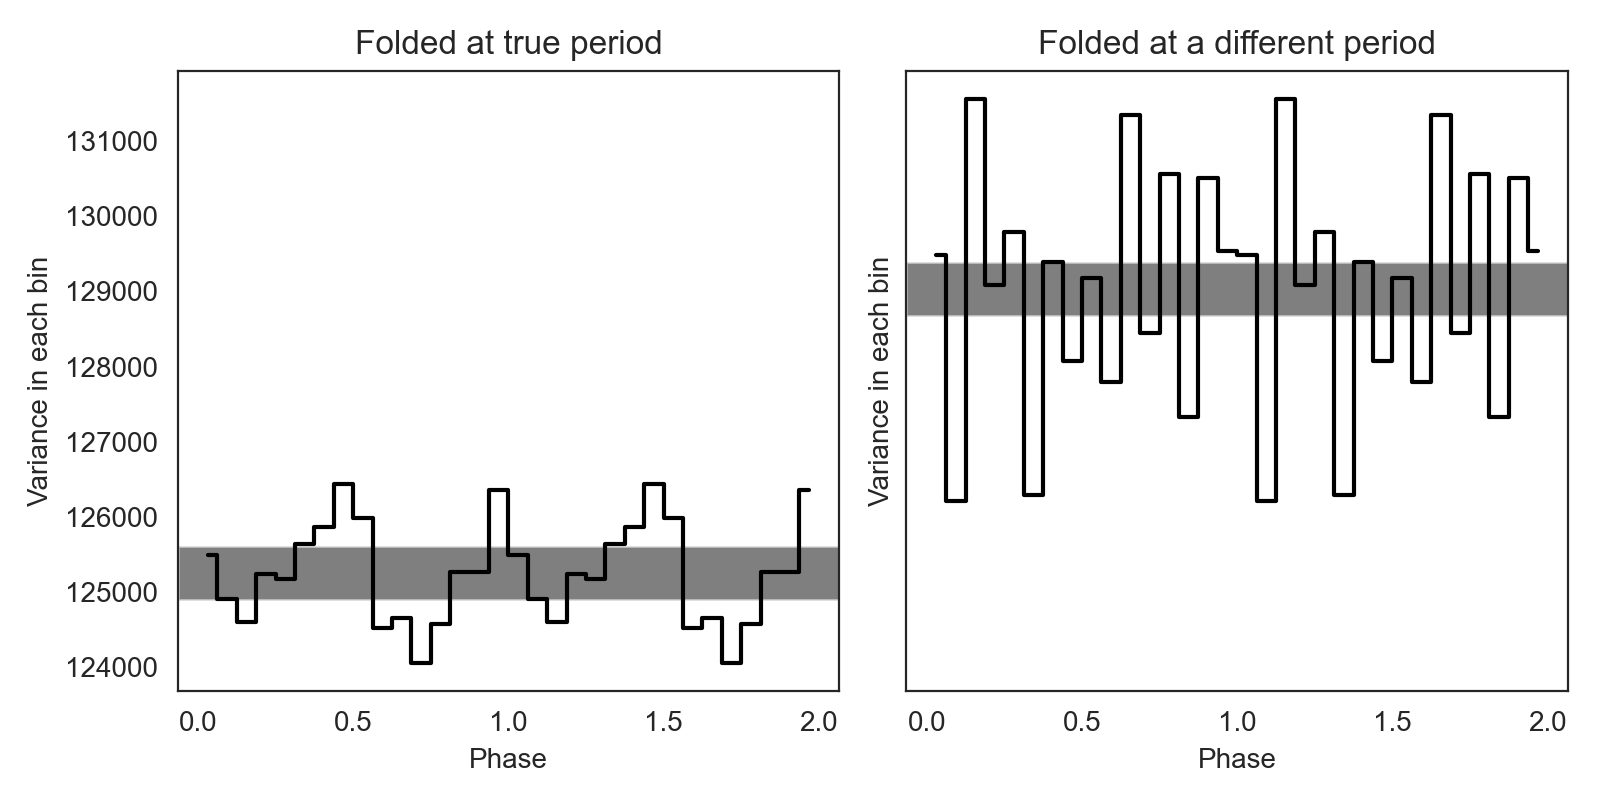

In [36]:
# number of bins in the phase-folded light curve
nbin = 16

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

ph1, profile1, profile_err1 = fold_events(lc.time, 1./period, nbin=nbin, 
                                          weights=lc.counts, mode="pdm")
_ = plot_profile(ph1, profile1, ax=ax1)
ax1.set_title("Folded at true period")
ax1.set_ylabel("Variance in each bin")

ph2, profile2, profile_err2 = fold_events(lc.time, 1.0, nbin=nbin, 
                                          weights=lc.counts, mode="pdm")
_ = plot_profile(ph2, profile2, ax=ax2)
ax2.set_title("Folded at a different period")
ax2.set_ylabel("Variance in each bin")
fig.tight_layout()

Note the differences in the y-axes. Let's calculate a periodogram the same way we have for the EF statistic:

In [37]:
from stingray.pulse import phase_dispersion_search

In [38]:
df_min = 1/obs_length # frequency resolution, independent frequencies

oversampling = 1.0 # oversampling factor

df = df_min / oversampling # frequency resolution with oversampling

# normally fmax = 0.5/dt, but we're setting it to 1.5 here to 
# keep computation time manageable
fmax = 1.5 # maximum frequency to search

# set up array of frequencies
frequencies = np.arange(df, fmax, df)

# compute phase dispersion minimization statistic for all trial frequencies
freq, pdmstat = phase_dispersion_search(lc.time, lc.counts, frequencies, nbin=nbin)


<IPython.core.display.Javascript object>


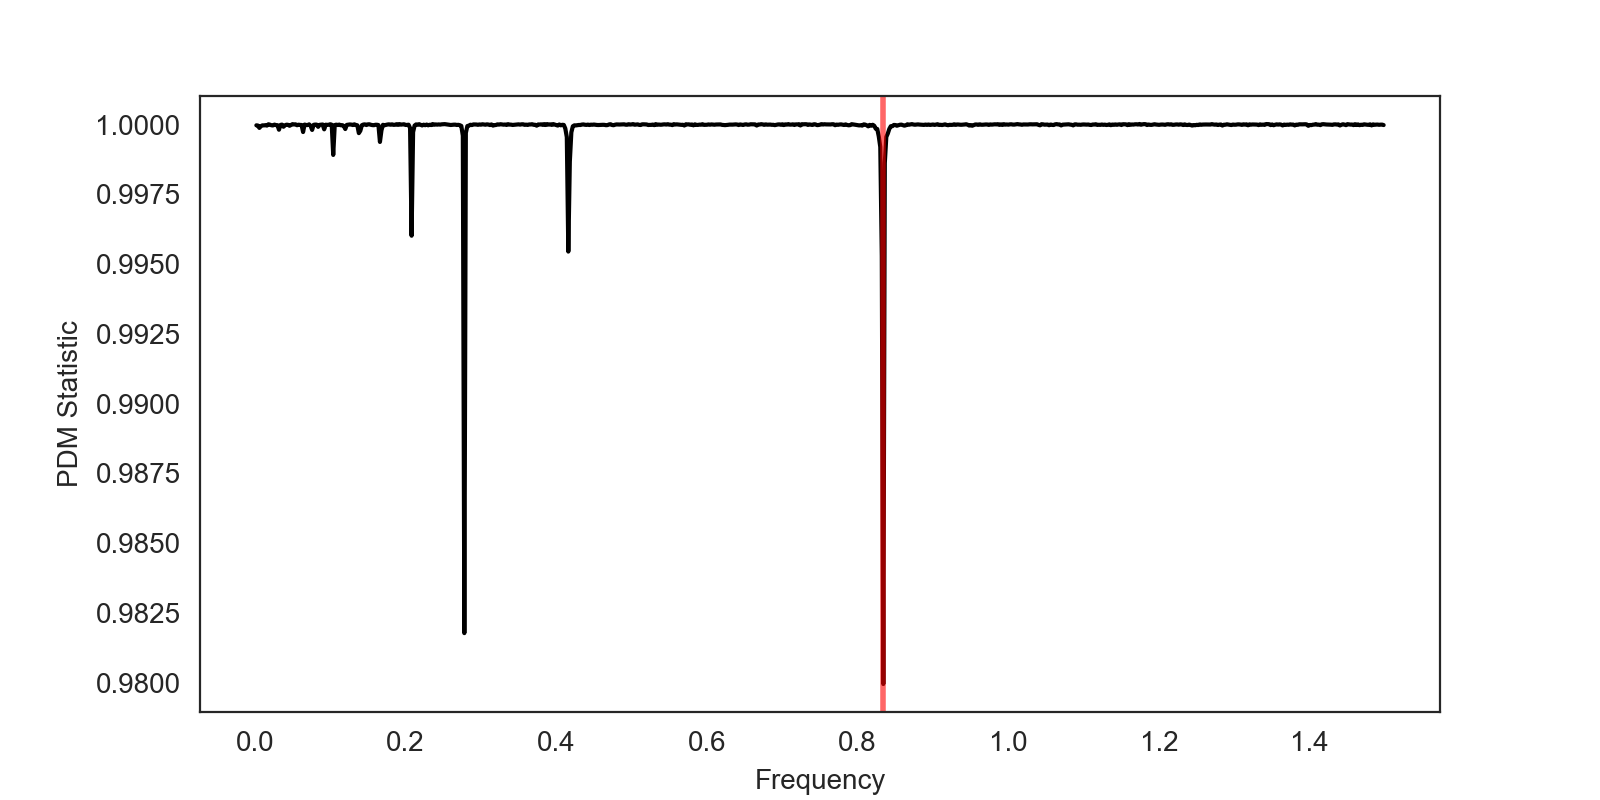

Text(0, 0.5, 'PDM Statistic')

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(freq, pdmstat, color="black")
ax.axvline(1./period, lw=2, color="red", alpha=0.6)
#ax.set_xlim(freq_zoom[0], freq_zoom[-1])
ax.set_xlabel("Frequency")
ax.set_ylabel("PDM Statistic")

In [40]:
nbin

16

Note the dip at the true frequency, which is exactly what we would expect! Because the phase dispersion minimization posits that the variance (and thus the PDM statistic) is *minimized* at the period if a signal is present, we are consequently searching for *dips* in the PDM statistic, rather than peaks.

Similarly to the EF statistic, we of course also want to test significance for the signal above. Though initially, [Stellingwerf (1978)]() assumed that the distribution of the test statistic for PDM was an $F$-distribution, [Schwarzenberg-Czerny (1997)]() showed that this is not the case, and that instead a beta-distribution should be used.

Of course, this is implemented in `stingray` as well:

In [41]:
from stingray.stats import phase_dispersion_detection_level
from stingray.stats import phase_dispersion_logprobability
from stingray.stats import phase_dispersion_probability

In [42]:
minpow = np.min(pdmstat)
minfreq = freq[np.argmin(pdmstat)]

ntrial = len(pdmstat)
nsamples = len(lc.time) # number of bins in the time series

In [43]:
nbin

16

/opt/miniconda3/envs/stingraydev/lib/python3.8/site-packages/stingray-1.1.dev3+gd8a1a13.d20230405-py3.8.egg/stingray/stats.py:275: RuntimeWarning: divide by zero encountered in log
  np.log(p1).astype(np.double), n)


<IPython.core.display.Javascript object>


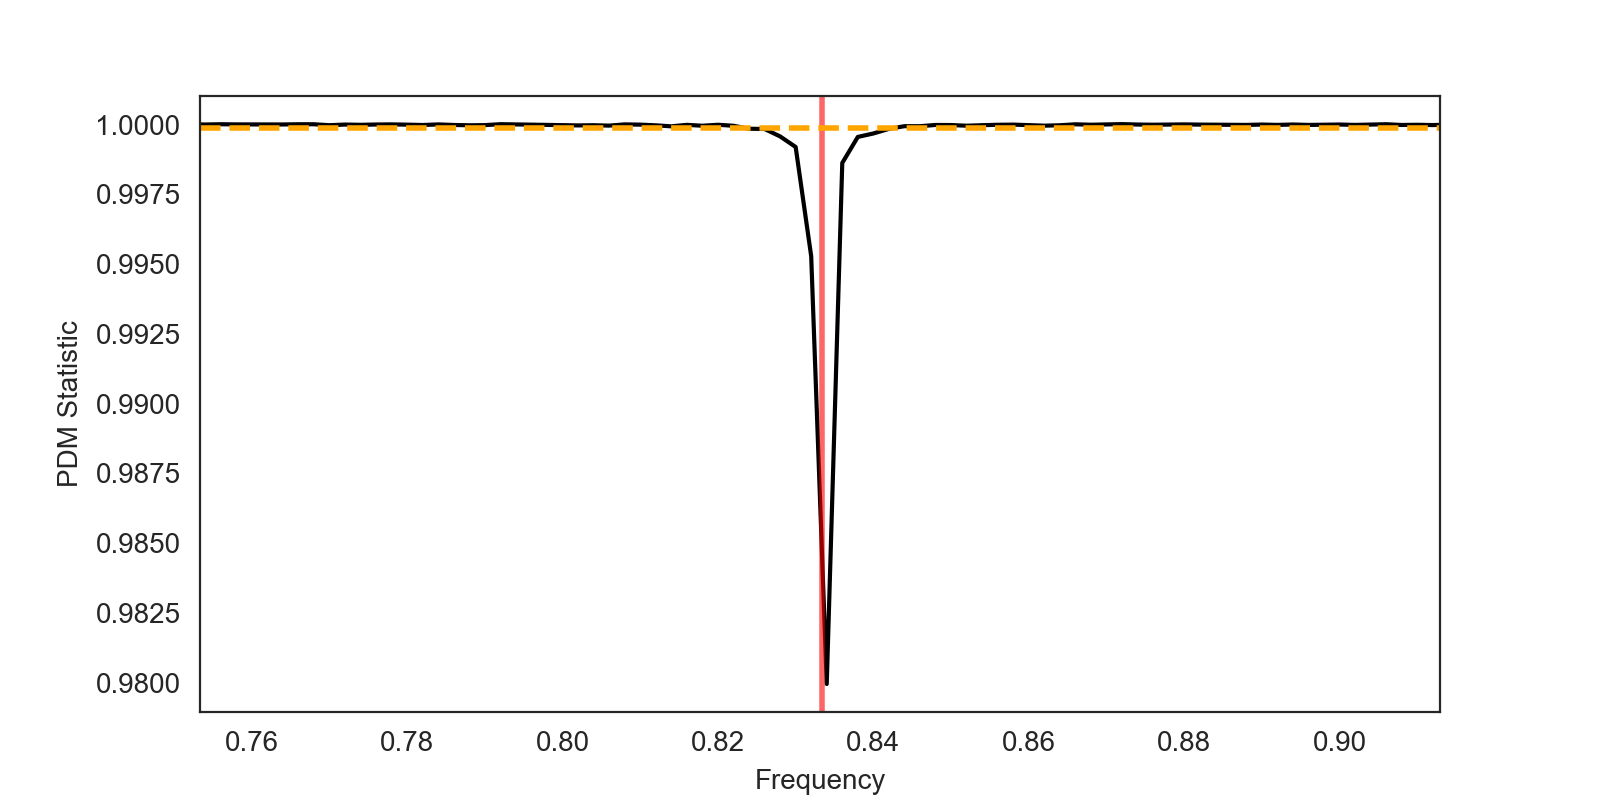

The minimum PDM statistic is 0.979946261427122 at frequency f=0.8340000000000001.
The probability for the minimum PDM statistic is p=0.0.
The log-probability for the minimum PDM statistic is p=-inf.


In [44]:
# PDM Detection level
pdm_detlev = phase_dispersion_detection_level(nsamples, nbin, 
                                              epsilon=0.001, ntrial=ntrial)

# PDM probabilities for smallest outlier
pdm_pval = phase_dispersion_probability(minpow, nsamples, nbin, ntrial=ntrial)
pdm_logpval = phase_dispersion_logprobability(minpow, nsamples, nbin, ntrial=ntrial)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(freq, pdmstat, color="black")
ax.axvline(1./period, lw=2, color="red", alpha=0.6)
ax.axhline(pdm_detlev, lw=2, color="orange", ls="dashed")
ax.set_xlim(freq_zoom[0], freq_zoom[-1])
ax.set_xlabel("Frequency")
ax.set_ylabel("PDM Statistic")

print(f"The minimum PDM statistic is {minpow} at frequency f={minfreq}.")
print(f"The probability for the minimum PDM statistic is p={pdm_pval}.")
print(f"The log-probability for the minimum PDM statistic is p={pdm_logpval}.")


Zoomed-in version:

In [45]:
df_min = 1/obs_length # frequency resolution, independent frequencies

oversampling = 5.0 # oversampling factor

df = df_min / oversampling # frequency resolution with oversampling

# set up array of frequencies
frequencies_zoom = np.arange(1./period - 200*df, 1./period + 200*df, df )

# compute epoch folding statistic for all trial frequencies
freq_zoom, pdmstat_zoom = phase_dispersion_search(lc.time, lc.counts, frequencies_zoom, 
                                              nbin=nbin)


In [46]:
pdm_detlev

0.9998885056977751

<IPython.core.display.Javascript object>


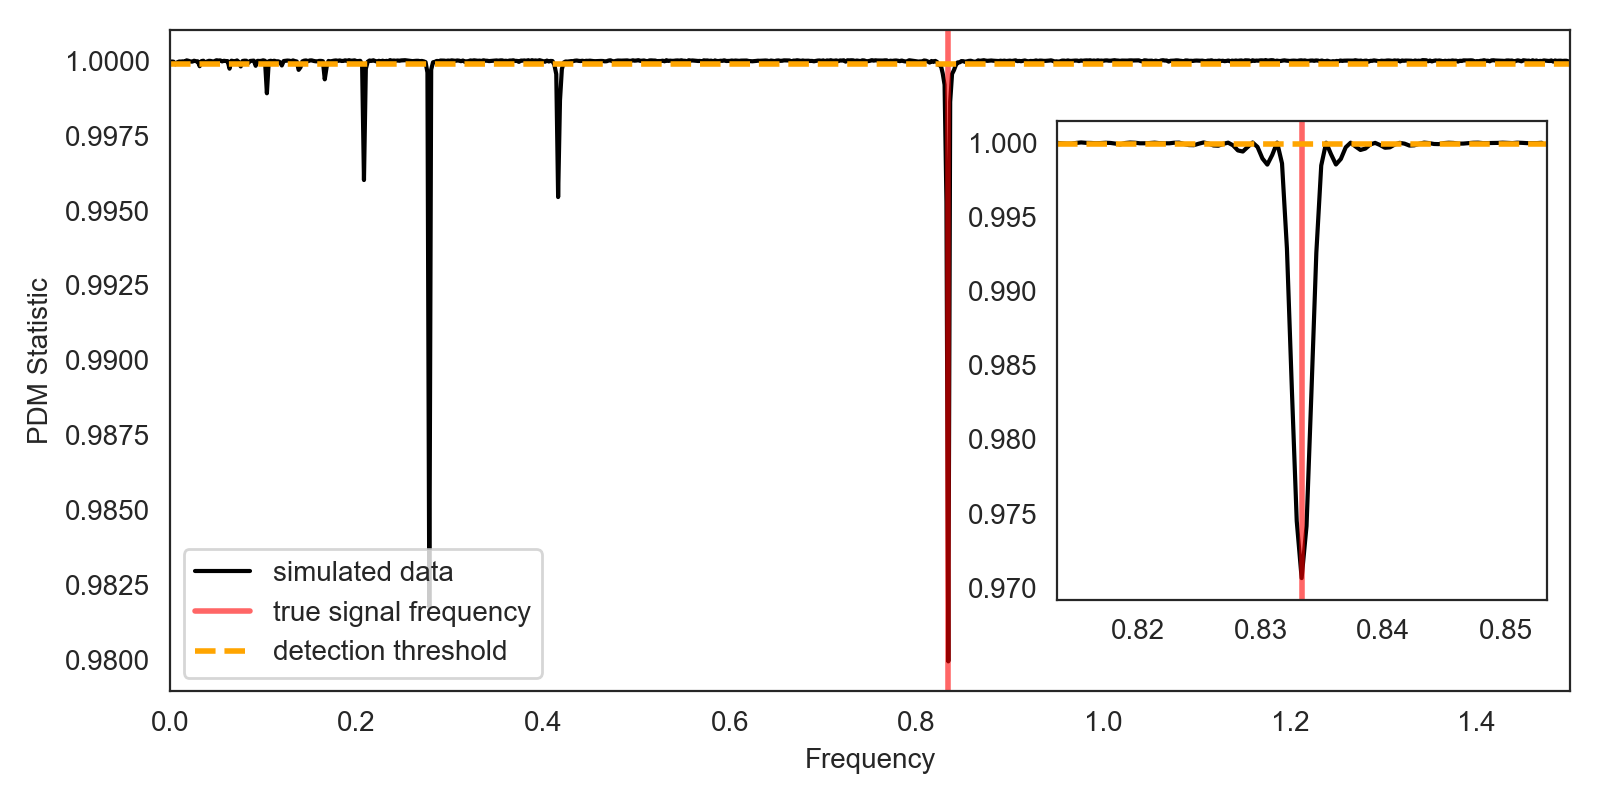

In [47]:
#from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
#                                                  mark_inset)
from matplotlib import lines
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox


fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(freq, pdmstat, color="black", label="simulated data")
ax.axvline(1./period, lw=2, color="red", alpha=0.6, label="true signal frequency")
ax.axhline(pdm_detlev, lw=2, color="orange", ls="dashed", label="detection threshold")

ax.set_xlim(0, 1.5)
#ax.set_ylim(0, 4000)
ax.set_xlabel("Frequency")
ax.set_ylabel("PDM Statistic")
ax.legend(loc="lower left")
fig.tight_layout()

bb_data_ax2 = Bbox.from_bounds(0.95, 0.982, 0.525, 0.016)
disp_coords = ax.transData.transform(bb_data_ax2)
fig_coords_ax2 = fig.transFigure.inverted().transform(disp_coords)
bb_ax2 = Bbox(fig_coords_ax2)
ax2 = fig.add_axes(bb_ax2)

ax2.plot(freq_zoom[150:250], pdmstat_zoom[150:250], color="black")
ax2.axvline(1./period, lw=2, color="red", alpha=0.6)
ax2.axhline(pdm_detlev, lw=2, color="orange", ls="dashed")
ax2.set_xlim(freq_zoom[150], freq_zoom[250])

fig.savefig(f"{figdir}pdm_stat.pdf", format="pdf")

The power of the EF statistic and the PDM statistic are directly related, as was shown through an Analysis of Variance by [Davies (1990)]():

$$
(N - 1) = (N - M)\Theta^2 + (M - 1) Q_*^2
$$

where $Q_*^2 = q^2 / (M-1)$ is the EF statistic and $\Theta^2$ is the PDM statistic: